In [30]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import utils
from bs4 import BeautifulSoup

In [2]:
products = pd.read_csv('data/DreamMarket_master_product.csv')

C:\Users\morga\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# utils.plot_null_val_heatmap(products, 'Null Values of Product Dataset')

## Functions - Add to utils.py

In [4]:
def convert_price_to_float(price):
    if price == '-':
        adj_price = np.NaN
    elif type(price) == float:
        adj_price = price
    elif type(price) == str:
        tmp = price.replace('$', '')
        adj_price = tmp.replace(',', '')
        adj_price = float(adj_price)
    
    return adj_price

## Clean and Process Data

In [5]:
products['is_2016'] = products['idproduct'].isnull()
products['year_sold'] = products['is_2016'].apply(lambda x: 2016 if True else 2017)
products.drop('is_2016', axis=1, inplace=True)

In [6]:
products['adj_price'] = products['price'].apply(lambda x: utils.convert_price_to_float(x))

In [7]:
products.head()

,seqNo,product_name,category,description,shipping_options,keywords,seller_name,price,payment_method,sold_since,ends_in,quantity_sold,quantity_left,refundPolicy,market_name,ship_from,ship_to,idproduct,year_sold,adj_price
0,1.0,503 - Forwarding failure (Privoxy@localhost),-,-,-,-,-,-,-,-,-,-,-,-,Dream,-,-,NaN,2016,NaN
1,2.0,OG KUSH 1/2 OZ $125 AAAA+,Drugs \n\t\t41793,OG Kush makes up the genetic backbone of West ...,\n\n\n$15.99\t\t\t\t\t\nCANADA WIDE\n\n\n\n\n\...,-,GWLOVE,$125,Escrow Yes,-,-,-,-,-,Dream,CANADA,Worldwide Worldwide,NaN,2016,125.0
2,3.0,Dream Market Login - Featured anonymous market...,-,-,-,-,-,-,-,-,-,-,-,-,Dream,-,-,NaN,2016,NaN
3,4.0,Every drug available on request,Drugs \n\t\t41804,Every kind of medicine I can arrange . Send me...,-,-,Hectorstuff,$1,Escrow Yes,-,-,-,-,-,Dream,dutch,Worldwide Worldwide,NaN,2016,1.0
4,5.0,"Debug, Learn how crack windows",Digital Goods \n\t\t29334,"Debug, Learn how crack windows",-,-,darkmarket,$1,Escrow Yes,-,-,-,-,-,Dream,Worldwide,Worldwide Worldwide,NaN,2016,1.0


In [8]:
utils.stats_summary(products['adj_price'])

STATS SUMMARY:
Mean:  1471.6691700309912
Median:  32.0
Std. Dev.:  226317.9385588906
Max value:  76949230.0
Min value:  0.0


# - Goods Less Than $100:  76638
% - Total Good Less Than $100: 58.5%


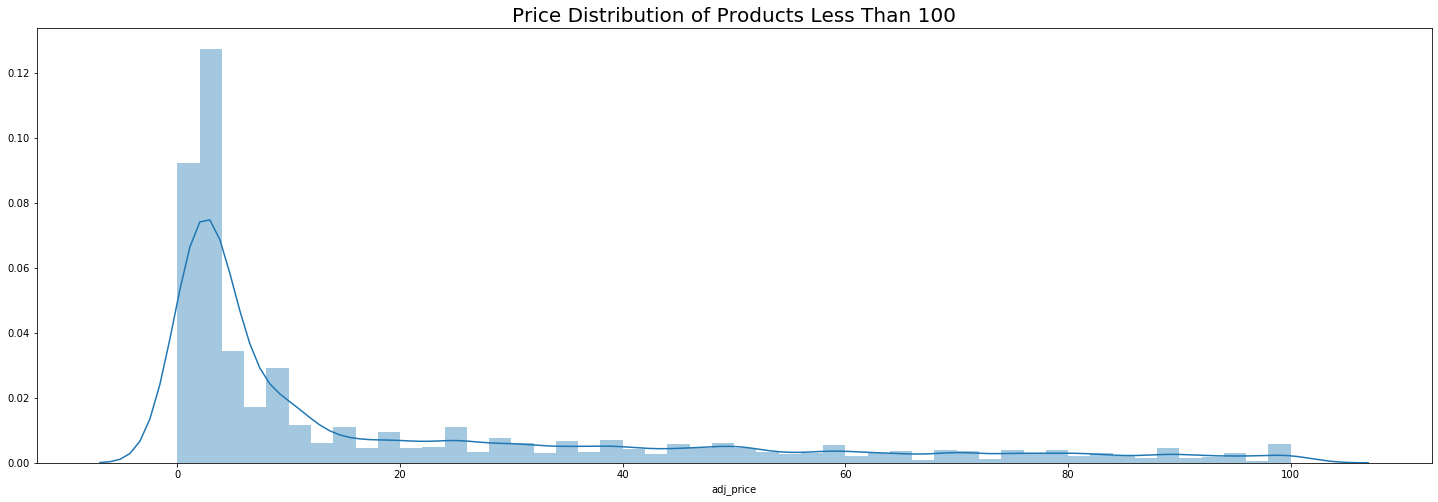

In [28]:
plt.figure(figsize=(25,8))
less_than_100 = products[products['adj_price'] < 100]['adj_price']
sns.distplot(less_than_100)
plt.title('Price Distribution of Products Less Than 100', fontsize= 20);
print('# - Goods Less Than $100: ', len(less_than_100))
print('% - Total Good Less Than $100: {:.1%}'.format(len(less_than_100) / products.shape[0]))

In [13]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130936 entries, 0 to 130935
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   seqNo             39473 non-null   float64
 1   product_name      130936 non-null  object 
 2   category          130936 non-null  object 
 3   description       130936 non-null  object 
 4   shipping_options  130936 non-null  object 
 5   keywords          130936 non-null  object 
 6   seller_name       130936 non-null  object 
 7   price             130936 non-null  object 
 8   payment_method    130936 non-null  object 
 9   sold_since        130936 non-null  object 
 10  ends_in           130936 non-null  object 
 11  quantity_sold     130936 non-null  object 
 12  quantity_left     130936 non-null  object 
 13  refundPolicy      130936 non-null  object 
 14  market_name       130936 non-null  object 
 15  ship_from         130932 non-null  object 
 16  ship_to           13

## Text Cleaning

In [32]:
products['category_revised'] = products['category'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())

In [47]:
products['category_revised'] = products['category'].str.replace(r'\n', '')
products['category_revised'] = products['category_revised'].str.replace('\t', '')
products['category_str'] = products['category_revised'].str.findall(r'[a-zA-Z]')
products['category_num'] = products['category_revised'].str.findall(r'[0-9]')

In [48]:
products.head()

,seqNo,product_name,category,description,shipping_options,keywords,seller_name,price,payment_method,sold_since,...,refundPolicy,market_name,ship_from,ship_to,idproduct,year_sold,adj_price,category_revised,category_str,category_num
0,1.0,503 - Forwarding failure (Privoxy@localhost),-,-,-,-,-,-,-,-,...,-,Dream,-,-,NaN,2016,NaN,-,[],[]
1,2.0,OG KUSH 1/2 OZ $125 AAAA+,Drugs \n\t\t41793,OG Kush makes up the genetic backbone of West ...,\n\n\n$15.99\t\t\t\t\t\nCANADA WIDE\n\n\n\n\n\...,-,GWLOVE,$125,Escrow Yes,-,...,-,Dream,CANADA,Worldwide Worldwide,NaN,2016,125.0,Drugs 41793,"[D, r, u, g, s]","[4, 1, 7, 9, 3]"
2,3.0,Dream Market Login - Featured anonymous market...,-,-,-,-,-,-,-,-,...,-,Dream,-,-,NaN,2016,NaN,-,[],[]
3,4.0,Every drug available on request,Drugs \n\t\t41804,Every kind of medicine I can arrange . Send me...,-,-,Hectorstuff,$1,Escrow Yes,-,...,-,Dream,dutch,Worldwide Worldwide,NaN,2016,1.0,Drugs 41804,"[D, r, u, g, s]","[4, 1, 8, 0, 4]"
4,5.0,"Debug, Learn how crack windows",Digital Goods \n\t\t29334,"Debug, Learn how crack windows",-,-,darkmarket,$1,Escrow Yes,-,...,-,Dream,Worldwide,Worldwide Worldwide,NaN,2016,1.0,Digital Goods 29334,"[D, i, g, i, t, a, l, G, o, o, d, s]","[2, 9, 3, 3, 4]"
